(Deep) Neural Network approach to the LHCb Ddownstream Tracking T-Seed selection. 
====================
Study description
-------------
This script contains all of my study based on deep and shalow neural networks.  
To constructs models I will use [Keras](https://keras.io/) with Theano background.  
All features are normalized. 

Study roadmap
----------------
1. Train 1 NN with ReLU nonlinearities  
   1.1 At first I use 200 hidden unit per layer  
   1.2  Try different drop-out and regularization layers (both L1 and L2)    
2. Use GridSearchCV to tune number of hidden layer
3. Train second Shallow Neural Network contains 2 hidden layers. Do simillar optimalization steps as prevoiusly. 
4. Train Deep Neural Network (at least 5 hidden layer). 


The previous models scores to beat:
----------
* kNN **0.787**
* Logistic Regresion **0.77**
* BDT (XGboost) **0.82 **
* Lasagne 1NN   **0.78722** 

In [1]:
print("Kernel is alive!")

Kernel is alive!


In [2]:
import root_numpy
import pandas as pd
import numpy
import numpy as np
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import validation_curve

import theano
import theano.tensor as T

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2, activity_l2
from keras.regularizers import l1, activity_l1
from keras.layers.normalization import BatchNormalization
from keras.optimizers import  RMSprop

theano.config.gcc.cxxflags="-march=sandybridge"

import time

Welcome to ROOTaaS 6.06/02
Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


Grab training data form the NTuple
--------------------------

In [3]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree, stop=1000000))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [4]:
def add_basic_features(data):
    #abs transformation
    out = data
    out["seed_x"]=numpy.abs(data['seed_x'])
    out["seed_y"]=numpy.abs(data['seed_y'])
    out["seed_tx"]=numpy.abs(data['seed_tx'])
    out["seed_ty"]=numpy.abs(data['seed_ty'])
    #log transformation
    out["seed_p"]= numpy.log(data['seed_p'])
    out["seed_pt"]= numpy.log(data['seed_pt'])
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))
    
    return out

In [5]:
data = add_basic_features(data)
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,pseudo_rapidity,seed_r
0,1.213708,7.841285,7.079410,25,0,12,1263.157617,517.249191,0.524220,0.061572,1.487361,1364.959300
1,1.346112,7.930741,7.093734,25,0,12,1264.522435,99.363473,0.480288,0.009081,1.443802,1268.420312
2,1.627632,8.469986,7.443378,25,0,12,1521.093160,196.064807,0.382802,0.025975,1.370450,1533.677219
3,1.789231,8.556975,7.508752,25,0,12,1563.145597,483.850246,0.369674,0.058753,1.364796,1636.317578
4,1.269238,7.741082,7.132965,24,0,12,1641.727752,411.084316,0.646627,0.054980,1.598503,1692.412576


Train Shallow Neural Network (1NN) 
==================
I try to train the shallow, contains only 1 hidden layer, neural network.  
The data is normalized via StandardScaler. 
I first network also contains dropout and regularization layer.  
The SNN is created using keras framework. To be able to use lot of sklearn features I will use keras sklearn [wrapper](https://keras.io/scikit-learn-api/)  
I will train this classifier during 10 epoch.

In [26]:
n_hidden = 400 
p_drop = 0.2
n_features = features.shape[1]

In [7]:
good_track_no = counts = features[target == 1].count()[0]
ghost_track_no = counts = features[target == 0].count()[0]
print("good tracks %d") % good_track_no
print("ghost track %d") % ghost_track_no
ratio_ghost_to_good = float(ghost_track_no)/good_track_no
ratio_ghost_to_good = numpy.round(ratio_ghost_to_good, 3)
print ("ratio ghost to good %f") % ratio_ghost_to_good

good tracks 63737
ghost track 936263
ratio ghost to good 14.689000


In [35]:
def create_1nn(n_features, n_hidden, p_drop, reg ):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(n_features,)))
    model.add(Dense(n_hidden,input_dim=n_features,
                    W_regularizer=l2(reg), activity_regularizer=activity_l2(reg)))
    model.add(Activation('relu'))
    #PReLU(input_shape=(n_hidden,))
    #model.add(Dropout(p_drop))
    model.add(Dense(2,input_dim=n_hidden))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer="rmsprop")
    return model

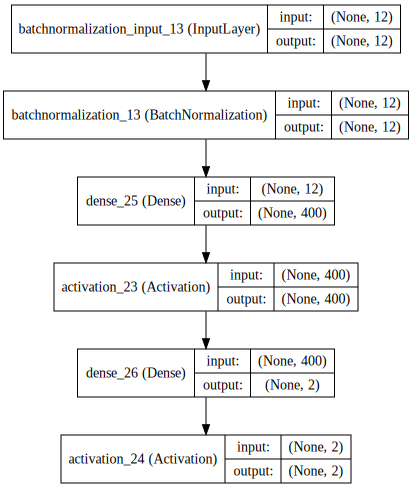

In [36]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
model = create_1nn ( n_features=n_features, n_hidden=n_hidden, p_drop=p_drop, reg  = 0.01 )
SVG(model_to_dot(model, show_shapes=True).create( prog='dot', format='svg'))

In [37]:
%%capture
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )

nb_epoch = 15
batch_size = 126 
n_features = trainX.shape[1]
class_weights = {1:ratio_ghost_to_good,
                 0:1}

# prepare Train 
trainY = trainY.values
y_train = np_utils.to_categorical(trainY)
trainX = trainX.values

clf = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('clf', KerasClassifier(build_fn = create_1nn , 
                         n_features=n_features, n_hidden=n_hidden, p_drop=p_drop, reg=0.01, class_weight=class_weights,
                          sample_weight = None,
                          batch_size=batch_size, nb_epoch=nb_epoch) )
])
clf.fit(trainX, y_train)
time.sleep(0.1)

In [39]:
print "Relu 400 Hidden unit"
roc_auc_score(testY, clf.predict_proba(testX)[:, 1])

Relu 400 Hidden unit
499716/500000 [============================>.] - ETA: 0s

0.76626729016595641

499338/500000 [============================>.] - ETA: 0s

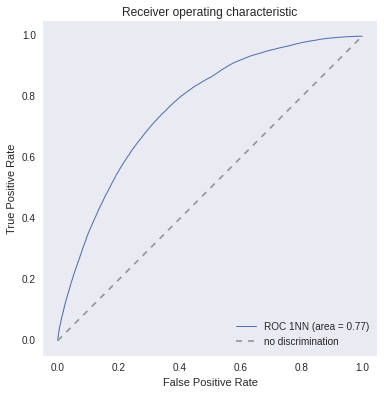

In [40]:

plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, clf.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC 1NN (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Try grid search to tune NN parameters
---------------------